In [14]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import torchvision.utils as vutils
import sys
import matplotlib
import numpy
import os
if 'DISPLAY' not in os.environ:
    matplotlib.use('Agg')
from matplotlib import pyplot as plt
from torchvision import utils
from sinkhorn import sinkhorn_loss

In [15]:
show_image=True
def imshow(inp, file_name, save=False, title=None):
    """Imshow for Tensor."""
    fig = plt.figure(figsize=(10, 10))
    inp = inp.numpy().transpose((1, 2, 0))
    inp[inp>1]=1
    inp[inp<-1]=-1
    plt.imshow(inp)
    plt.savefig(file_name)
    if show_image:
        plt.show()
    else:
        print("Don't show")

In [16]:
z_size=128
hidden_size=64
img_size=32
niter=100
epsilon=1

In [17]:
root = './data'
download = True
trans = transforms.Compose([
    transforms.Scale(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_set = dset.MNIST(
    root=root, train=True, transform=trans, download=download)
test_set = dset.MNIST(root=root, train=False, transform=trans)
batch_size = 200
kwargs = {}
D_loader = torch.utils.data.DataLoader(
    dataset=train_set, batch_size=batch_size, shuffle=True)
G_loader = torch.utils.data.DataLoader(
    dataset=train_set, batch_size=batch_size, shuffle=True)

In [18]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(z_size,hidden_size*8,4,2,1),
            nn.BatchNorm2d(hidden_size*8),
            nn.ReLU(True),
            nn.ConvTranspose2d(hidden_size*8,hidden_size*4,4,2,1),
            nn.BatchNorm2d(hidden_size*4),
            nn.ReLU(True),
            nn.ConvTranspose2d(hidden_size*4,hidden_size*2,4,2,1),
            nn.BatchNorm2d(hidden_size*2),
            nn.ReLU(True),
            nn.ConvTranspose2d(hidden_size*2,hidden_size,4,2,1),
            nn.BatchNorm2d(hidden_size*1),
            nn.ReLU(True),
            nn.ConvTranspose2d(hidden_size,1,4,2,1),
            nn.Tanh(),
        )
    def forward(self, x):
        x = x.view(x.size()[0], z_size, 1, 1)
        out = self.model(x)
        out = out.view(x.size()[0], 1, img_size,img_size)
        return out

In [19]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main=nn.Sequential(
            nn.Linear(100,100)
        )

    def forward(self, x):
        x = x.view(x.size(0), img_size * img_size)
        return x

In [20]:
one = torch.FloatTensor([1])
noise_holder=torch.FloatTensor(batch_size, z_size, 1, 1)
input_holder = torch.FloatTensor(batch_size, 1, img_size, img_size)
if torch.cuda.is_available():
    one=one.cuda()
    noise_holder=noise_holder.cuda()
    input_holder=input_holder.cuda()
mone = one * -1

In [21]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


  0%|          | 0/10000 [00:00<?, ?it/s]

Generator (
  (model): Sequential (
    (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU (inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU (inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (8): ReLU (inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (11): ReLU (inplace)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): Tanh ()
  )
)



Exception in thread Thread-8:
Traceback (most recent call last):
  File "/Users/sunxiaofei/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/sunxiaofei/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/sunxiaofei/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



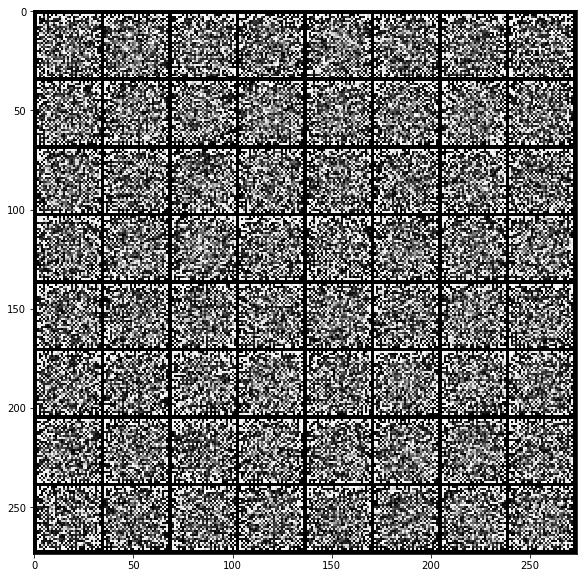

  0%|          | 5/10000 [01:14<41:38:02, 15.00s/it]


KeyboardInterrupt: 

In [22]:
from tqdm import tqdm
G = Generator()
G.apply(weights_init)
D = Discriminator()
print(G)
if torch.cuda.is_available():
    G.cuda()
    D.cuda()
G_lr = D_lr = 5e-5
optimizers = {
    'D': torch.optim.RMSprop(D.parameters(), lr=D_lr),
    'G': torch.optim.RMSprop(G.parameters(), lr=G_lr)
}
criterion = nn.BCELoss()
for epoch in tqdm(range(10000)):
    optimizers['G'].zero_grad()
    data=next(iter(G_loader))[0]
    input_holder.resize_as_(data).copy_(data)
    y = D(Variable(data))
    noise_holder.resize_(data.size()[0], z_size, 1, 1).normal_(0, 1)
    noisev = Variable(noise_holder)
    fake_data = G(noisev)
    x = D(fake_data)
    W_xy=sinkhorn_loss(x,y,epsilon,batch_size,niter)
    W_xx=sinkhorn_loss(x,x,epsilon,batch_size,niter)
    W_yy=sinkhorn_loss(y,y,epsilon,batch_size,niter)
    Loss_G=2*W_xy-W_xx-W_yy
    Loss_G.backward(one)
#     G_loss = -torch.mean(output_fake1)

#     G_loss.backward()
    optimizers['G'].step()

    if epoch % 100 == 0:
        if torch.cuda.is_available():
            dd = utils.make_grid(fake_data.cpu().data[:64])
        else:
            dd = utils.make_grid(fake_data.data[:64])
        imshow(dd,'./results/WGAN_DC_%d.png'%(epoch))
        dd = dd.mul(0.5).add(0.5)
        vutils.save_image(dd, './results/OrWGAN_DC_%d.png'%(epoch))